# sucrose Behavioral Research: Does time-restricted sucrose and/or diet change the sucrose behavior of animals?

This Jupyter notebook performs **1-way ANOVA and Tukey** on the sucrose activity of the restricted-access rats. The 1-way ANOVA is performed separately for each of the 2 diet groups. It will compare the variables of (1) Hour.

In other words, I will be performing **1-way ANOVA and Tukey** 2 times, once for each restricted-access group. Each 1-way ANOVA will test the hypothesis: **does the rate of sucrose activity (chow consumption) differ in any of the 3 hours ?** Then, Tukey will test the hypothesis: **if the rate of sucrose activity does differ, then in which of the 3 hours is it significantly higher or lower?**

## Import Libraries

In [1]:
#----------------------------------------------------------
# Import important libraries
#----------------------------------------------------------
import pandas as pd
import numpy as np
import datetime
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp

## Define Custom Methods

In [2]:
#----------------------------------------------------------
# Method to run Anova
#----------------------------------------------------------
def anova_analysis(anova_data):
    
    # The numerical response variable (Consumption Rate - number of seconds spent sucrose) and 
    # the categorical explanatory variable (Phase Type)
    formula = 'Consumption_Rate ~ C(phase)'
    
    # Setting up the linear model
    model = ols(formula, anova_data).fit()
    
    # I am using Type I ANOVA because that is the type of ANOVA used in R
    aov_table = anova_lm(model, typ=1)
    return aov_table

## Read in CSV Files with Binary sucrose Behavior

In [3]:
# Links to all CSV files
hfhs_restr_sucrose_location = "https://www.dropbox.com/s/f24su76nrsp5hxq/Sucrose_HFHS_Restricted_Binary.csv?dl=1"
hfhs_adlib_sucrose_location = "https://www.dropbox.com/s/fsafpttmodnxm90/Sucrose_HFHS_AdLib_Binary.csv?dl=1"

# Sucrose
hfhs_restr_sucrose = pd.read_csv(hfhs_restr_sucrose_location, index_col='Date_Time', parse_dates=True)
hfhs_adlib_sucrose = pd.read_csv(hfhs_adlib_sucrose_location, index_col='Date_Time', parse_dates=True)

hfhs_adlib_sucrose.head()

,Rat21,Rat22,Rat23,Rat26,Rat27
Date_Time,,,,,
1970-01-01 21:00:00,0,0,0,0,1.0
1970-01-01 21:00:01,0,0,0,0,1.0
1970-01-01 21:00:02,0,0,0,0,1.0
1970-01-01 21:00:03,0,0,0,0,1.0
1970-01-01 21:00:04,0,0,0,0,1.0


In these CSV files, there is a datetime index that is separated into 1-second intervals. Each of the columns represents a different rat. The only possible column values are:
* **1** (which means that the rat is sucrose in that 1-second interval)
* **0** (which means that the rat is *not* sucrose in that 1-second interval)
* **NaN** (which means there was no video activity recorded for that rat during that 1-second interval)

## Download file with diet group information

In [4]:
#----------------------------------------------------------
# Import CSV with diet and sucrose access for each rat
#----------------------------------------------------------
groups_location = 'https://www.dropbox.com/s/37toe3vct1pipn5/groups.csv?dl=1'
groups_data = pd.read_csv(groups_location , index_col=0)
groups_data.head() 

,diet,feeding
Rat,,
1,control,ad lib
2,control,ad lib
3,control,ad lib
4,control,ad lib
5,control,ad lib


## Create New Dataframes that: 
1. **Resample the Binary Data by 1 Hour.**

This will calculate the **Hourly sucrose Activity** for every rat (number of seconds spent sucrose in each hour). After calculating this Hourly sucrose Activity, I will only select the hours in the 8-hour restricted sucrose window (from 23:00 to 7:00)

2. **Divide the Hourly sucrose Activity dataframes into 3 phases (First 2 hours, Mid 4 hours, and Last 2 hours)**

### 1. Resample the Binary Data by 1 Hour.

In [5]:
# Resample all of the dataframes by 1 Hour. I couldn't do just .resample ("1H") because that would 
# replace NaN values with 0's, which is artificially skewing the data
hfhs_adlib_sucrose_hourly = hfhs_adlib_sucrose.resample("1H",how=lambda x: x.values.sum()).T
hfhs_restr_sucrose_hourly = hfhs_restr_sucrose.resample("1H",how=lambda x: x.values.sum()).T

# Combine all 2 new dataframes into one list
hourly_sucrose_frames = [hfhs_adlib_sucrose_hourly, hfhs_restr_sucrose_hourly]

# Concatenate/Merge all 2 dataframes into 1 dataframe
sucrose_hourly_frame = pd.concat(hourly_sucrose_frames)

# Set the index of the new dataframe as just the rat numbers (i.e. "2" instead of "Rat2"). 
# This will set the index to the same index as the groups_data dataframe
sucrose_hourly_frame.index = sucrose_hourly_frame.index.map(lambda x: int(str(x)[3:]))

# Add a new column that holds the diet group information (which of the 4 diet groups that the rat belongs to)
sucrose_hourly_frame['group']=groups_data.loc[sucrose_hourly_frame.index].diet+' '+groups_data.loc[sucrose_hourly_frame.index].feeding

# Rename all of the columns into actual hour times - making it easier to choose columns
sucrose_hourly_frame.columns = ["21:00", "22:00", "23:00", "0:00", "1:00", "2:00", "3:00", "4:00",
                                "5:00", "6:00", "7:00", "8:00", "9:00", "10:00", "11:00", "12:00",
                                "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00",
                                "group"]

# Select only the final 3 hours of interest (from 4:00 to 7:00)
final_hours_of_interest = sucrose_hourly_frame[["4:00", "5:00", "6:00", "group"]]
final_hours_of_interest = final_hours_of_interest[(final_hours_of_interest["group"] == "HFHS ad lib") | (final_hours_of_interest["group"] == "HFHS restriction")]

# Select only the first 3 hours of interest (from 23:00 to 2:00)
first_hours_of_interest = sucrose_hourly_frame[["23:00", "0:00", "1:00", "group"]]
first_hours_of_interest = first_hours_of_interest[(first_hours_of_interest["group"] == "HFHS ad lib") | (first_hours_of_interest["group"] == "HFHS restriction")]

# Preview
first_hours_of_interest

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  after removing the cwd from sys.path.


,23:00,0:00,1:00,group
21,102.0,0.0,129.0,HFHS ad lib
22,18.0,0.0,156.0,HFHS ad lib
23,63.0,47.0,70.0,HFHS ad lib
26,37.0,0.0,28.0,HFHS ad lib
27,33.0,0.0,182.0,HFHS ad lib
29,191.0,0.0,45.0,HFHS restriction
30,32.0,32.0,0.0,HFHS restriction
31,6.0,36.0,153.0,HFHS restriction
32,151.0,33.0,157.0,HFHS restriction
33,187.0,71.0,23.0,HFHS restriction


Here is a dataframe showing the sucrose activity of each rat from 23:00 to 7:00. The index represents each rat number. The *group* column represents what diet group the rat was in. The column values represent the number of seconds that the rat spent sucrose for that hour. 

For example, in the first cell (upper left cell), it contains the value 1090.0. That means that Rat02 (row index)  spent 1090 seconds sucrose during the time interval from 23:00 to 23:59:59 (column header). Rat02 was also in the *control ad lib* diet group.

### 2. Divide the Hourly sucrose Activity dataframes into 3 phases (First 2 hours, Mid 4 hours, and Last 2 hours)

I will create 3 dataframes - one for each phase, then I will merge these dataframes into one. The final dataframe will be used for 1-way ANOVA. 

I am making 3 dataframes because the data needs to be prepared a certain way for 1-way ANOVA in Python:

* 1 column with diet group classification
* 1 column with phase type classification
* 1 column with the hourly sucrose values (or hourly consumption rate)

Here is a preview of what it should look like for 1-way ANOVA:

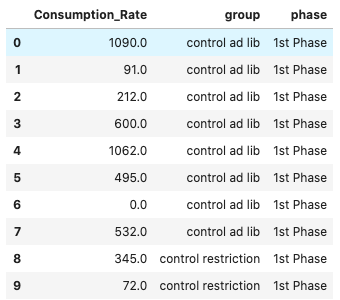

Notice that I do not have the rat numbers. They are not needed for 1-way ANOVA as long as I have the diet *group* and *phase* classification. The index can also be arbitrary.

In [6]:
#----------------------------------------------------------
# 6th Hour Dataframe
#----------------------------------------------------------
# Create an empty dataframe
final_first_phase = pd.DataFrame()

# Combine/Merge the hourly sucrose values from the first 2 hours into a single column
final_first_phase["Consumption_Rate"] = pd.concat([final_hours_of_interest["4:00"]])

# Add the "group" column into this dataframe
final_first_phase["group"] = final_hours_of_interest["group"]

# Create a new column with just the label "1st Phase" for all of the column values
final_first_phase["phase"] = "6th Hour"

# Make an arbitary index
final_first_phase = final_first_phase.reset_index(drop = True)

# Follow the same procedure for the other 2 phases.
# The only difference is the hours chosen for the "Consumption_Rate" column
#----------------------------------------------------------
# 7th Hour Dataframe
#----------------------------------------------------------
final_mid_phase = pd.DataFrame()
final_mid_phase["Consumption_Rate"] = pd.concat([final_hours_of_interest["5:00"]])
final_mid_phase["group"] = final_hours_of_interest["group"]
final_mid_phase["phase"] = "7th Hour"
final_mid_phase = final_mid_phase.reset_index(drop = True)

#----------------------------------------------------------
# 8th Hour Dataframe
#----------------------------------------------------------
final_last_phase = pd.DataFrame()
final_last_phase["Consumption_Rate"] = pd.concat([final_hours_of_interest["6:00"]])
final_last_phase["group"] = final_hours_of_interest["group"]
final_last_phase["phase"] = "8th Hour"
final_last_phase = final_last_phase.reset_index(drop = True)

# Perform the same process for the first 3 hours as well
#----------------------------------------------------------
# 1st Hour Dataframe
#----------------------------------------------------------
# Create an empty dataframe
first_first_phase = pd.DataFrame()

# Combine/Merge the hourly sucrose values from the first 2 hours into a single column
first_first_phase["Consumption_Rate"] = pd.concat([first_hours_of_interest["23:00"]])

# Add the "group" column into this dataframe
first_first_phase["group"] = first_hours_of_interest["group"]

# Create a new column with just the label "1st Phase" for all of the column values
first_first_phase["phase"] = "1st Hour"

# Make an arbitary index
first_first_phase = first_first_phase.reset_index(drop = True)

# Follow the same procedure for the other 2 phases.
# The only difference is the hours chosen for the "Consumption_Rate" column
#----------------------------------------------------------
# Middle Phase Dataframe
#----------------------------------------------------------
first_mid_phase = pd.DataFrame()
first_mid_phase["Consumption_Rate"] = pd.concat([first_hours_of_interest["0:00"]])
first_mid_phase["group"] = first_hours_of_interest["group"]
first_mid_phase["phase"] = "2nd Hour"
first_mid_phase = first_mid_phase.reset_index(drop = True)

#----------------------------------------------------------
# Last Phase Dataframe
#----------------------------------------------------------
first_last_phase = pd.DataFrame()
first_last_phase["Consumption_Rate"] = pd.concat([first_hours_of_interest["1:00"]])
first_last_phase["group"] = first_hours_of_interest["group"]
first_last_phase["phase"] = "3rd Hour"
first_last_phase = first_last_phase.reset_index(drop = True)

# Preview
first_last_phase.head(10)

,Consumption_Rate,group,phase
0,129.0,HFHS ad lib,3rd Hour
1,156.0,HFHS ad lib,3rd Hour
2,70.0,HFHS ad lib,3rd Hour
3,28.0,HFHS ad lib,3rd Hour
4,182.0,HFHS ad lib,3rd Hour
5,45.0,HFHS restriction,3rd Hour
6,0.0,HFHS restriction,3rd Hour
7,153.0,HFHS restriction,3rd Hour
8,157.0,HFHS restriction,3rd Hour
9,23.0,HFHS restriction,3rd Hour


### Create a single dataframe for 1-WAY ANOVA

In [7]:
#----------------------------------------------------------
# 1-Way ANOVA Dataframe
#----------------------------------------------------------
# Combine all of the 3 previous dataframes into 1
final_anova_frame = pd.concat([final_first_phase, final_mid_phase, final_last_phase])
final_anova_frame['group_and_phase'] = final_anova_frame["group"].astype(str) +" "+ final_anova_frame["phase"].astype(str)
final_anova_frame = final_anova_frame.dropna()

# Combine all of the 3 previous dataframes into 1
first_anova_frame = pd.concat([first_first_phase, first_mid_phase, first_last_phase])
first_anova_frame['group_and_phase'] = first_anova_frame["group"].astype(str) +" "+ first_anova_frame["phase"].astype(str)
first_anova_frame = first_anova_frame.dropna()
first_anova_frame

,Consumption_Rate,group,phase,group_and_phase
0,102.0,HFHS ad lib,1st Hour,HFHS ad lib 1st Hour
1,18.0,HFHS ad lib,1st Hour,HFHS ad lib 1st Hour
2,63.0,HFHS ad lib,1st Hour,HFHS ad lib 1st Hour
3,37.0,HFHS ad lib,1st Hour,HFHS ad lib 1st Hour
4,33.0,HFHS ad lib,1st Hour,HFHS ad lib 1st Hour
5,191.0,HFHS restriction,1st Hour,HFHS restriction 1st Hour
6,32.0,HFHS restriction,1st Hour,HFHS restriction 1st Hour
7,6.0,HFHS restriction,1st Hour,HFHS restriction 1st Hour
8,151.0,HFHS restriction,1st Hour,HFHS restriction 1st Hour
9,187.0,HFHS restriction,1st Hour,HFHS restriction 1st Hour


### Perform 1-Way ANOVA for each diet group and Tukey PostHoc

In [9]:
#----ANOVA for First 3 Hours------
# Perform 1-Way ANOVA and place the results in a dataframe
anova_df = anova_analysis(first_anova_frame)

# Perform Tukey post-hoc
mc_interaction = statsmodels.stats.multicomp.MultiComparison(first_anova_frame["Consumption_Rate"], first_anova_frame['group_and_phase'])
# The problem with .tukeyhsd (or pairwise_tukeyhsd) in python or statsmodels is that the p-adj values are bound by 0.001 or 0.9 so exact values 
# outside these intervals cannot be given - exact values can be calculated in R. But for our data,
# I don't think it's a problem since our alpha is set to 0.05
mc_interaction_results = mc_interaction.tukeyhsd(alpha = 0.05)

# Place the Tukey results in a dataframe
mc_interaction = pd.DataFrame(data=mc_interaction_results._results_table.data[1:], columns=mc_interaction_results._results_table.data[0])

# Print out the diet type
print(first_anova_frame.group.unique())
print("\n")

# Combine the 1-Way ANOVA results and Tukey PostHoc results into 1 dataframe
result = pd.concat([anova_df, mc_interaction], axis = 0, sort = False)

# If there are significant results, print out the phase types and p-values, else print "No significant results"
if result["reject"].sum() > 0:
    print(result.loc[:, ["group1", "group2", "p-adj", "reject"]].to_string(index = False))
    print("\n")
else:
    print ("No significant results\n")

#----ANOVA for Final 3 Hours------   
# Perform 1-Way ANOVA and place the results in a dataframe
anova_df = anova_analysis(final_anova_frame)

# Perform Tukey post-hoc
mc_interaction = statsmodels.stats.multicomp.MultiComparison(final_anova_frame["Consumption_Rate"], final_anova_frame['group_and_phase'])
# The problem with .tukeyhsd (or pairwise_tukeyhsd) in python or statsmodels is that the p-adj values are bound by 0.001 or 0.9 so exact values 
# outside these intervals cannot be given - exact values can be calculated in R. But for our data,
# I don't think it's a problem since our alpha is set to 0.05
mc_interaction_results = mc_interaction.tukeyhsd(alpha = 0.05)

# Place the Tukey results in a dataframe
mc_interaction = pd.DataFrame(data=mc_interaction_results._results_table.data[1:], columns=mc_interaction_results._results_table.data[0])

# Print out the diet type
print(final_anova_frame.group.unique())
print("\n")

# Combine the 1-Way ANOVA results and Tukey PostHoc results into 1 dataframe
result = pd.concat([anova_df, mc_interaction], axis = 0, sort = False)

# If there are significant results, print out the phase types and p-values, else print "No significant results"
if result["reject"].sum() > 0:
    print(result.loc[:, ["group1", "group2", "p-adj", "reject"]].to_string(index = False))
    print("\n")
else:
    print ("No significant results\n")

['HFHS ad lib' 'HFHS restriction']


                    group1                     group2   p-adj reject
                       NaN                        NaN     NaN    NaN
                       NaN                        NaN     NaN    NaN
      HFHS ad lib 1st Hour       HFHS ad lib 2nd Hour  0.9000  False
      HFHS ad lib 1st Hour       HFHS ad lib 3rd Hour  0.6610  False
      HFHS ad lib 1st Hour  HFHS restriction 1st Hour  0.0998  False
      HFHS ad lib 1st Hour  HFHS restriction 2nd Hour  0.9000  False
      HFHS ad lib 1st Hour  HFHS restriction 3rd Hour  0.9000  False
      HFHS ad lib 2nd Hour       HFHS ad lib 3rd Hour  0.1722  False
      HFHS ad lib 2nd Hour  HFHS restriction 1st Hour  0.0084   True
      HFHS ad lib 2nd Hour  HFHS restriction 2nd Hour  0.9000  False
      HFHS ad lib 2nd Hour  HFHS restriction 3rd Hour  0.7076  False
      HFHS ad lib 3rd Hour  HFHS restriction 1st Hour  0.8506  False
      HFHS ad lib 3rd Hour  HFHS restriction 2nd Hour  0.2660  Fal

Not enough statistical power (low sample size) to show that there is binging in the first few hours of food access or sucrose access

For reference, here is the figure:

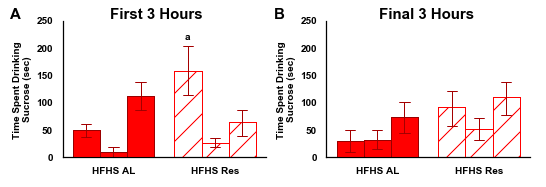

"a" - p < 0.05 between 1st and 2nd Hour


We can see according to the 1-Way ANOVA and Tukey results:

**HFHS diet with TRF induces excessive food consumption in the last phase**

For the HFHS restricted rats, they spent significantly more time sucrose in the last hour than the Control restricted rats did in the last hour. In fact, the HFHS restricted rats spent significnantly more time sucrose in the last hour than in the 2 hours prior or any of the 3 hours of the Control-Restricted rats
